In [1]:
from __future__ import print_function

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole

import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from collections import defaultdict, Counter

#import the rxn role assignment functionality from the rdkit contrib directory
import sys
from rdkit.Chem import RDConfig
sys.path.append(RDConfig.RDContribDir)

from RxnRoleAssignment import identifyReactants, utils
import utilsEvaluation

In [2]:
%matplotlib inline

#### Load the data

In [3]:
rxnCls = pickle.load(file('data/rxnClasses.pickle'))

In [4]:
dataSetB = pd.read_csv('data/dataSetB.csv')

In [5]:
dataSetB.head()

,rxn_Class,patentID,rxnSmiles_Mapping_NameRxn,reactantSet_NameRxn,NameRxn_Mapping_Complete,rxnSmiles_Mapping_IndigoTK,reactantSet_IndigoTK,IndigoTK_Mapping_Complete,rxnSmiles_IndigoAutoMapperKNIME,reactantSet_IndigoAutoMapperKNIME,IndigoAutoMapperKNIME_Mapping_Complete
0,6,US05849732,C.CCCCCC.CO.O=C(OCc1ccccc1)[NH:1][CH2:2][CH2:3...,"set([3, 4])",True,C(OC([NH:11][CH2:12][CH2:13][CH2:14][CH2:15][C...,"set([0, 2])",True,C.CCCCCC.CO.[CH3:10][O:11][C:12]([C@@H:14]([NH...,"set([3, 4])",True
1,2,US20120114765A1,O[C:1](=[O:2])[c:3]1[cH:4][c:5]([N+:6](=[O:7])...,"set([0, 1])",True,[Cl:1][c:2]1[cH:3][n:4][cH:5][c:6]([Cl:20])[c:...,"set([0, 1])",True,[NH2:1][c:2]1[c:11]2[c:6]([cH:7][n:8][cH:9][cH...,"set([0, 1])",True
2,1,US08003648B2,Cl.O=[CH:1][c:2]1[cH:3][cH:4][c:5](-[c:6]2[n:7...,"set([1, 3])",True,[CH2:1]([NH:3][CH2:4][CH3:5])[CH3:2].C([BH3-])...,"set([0, 3])",True,[CH3:1][CH2:2][NH:3][CH2:4][CH3:5].[CH3:6][c:7...,"set([0, 1])",True
3,1,US09045475B2,CC(=O)O[BH-](OC(C)=O)OC(C)=O.ClCCl.O=[C:1]([CH...,"set([2, 3])",True,[nH:1]1[c:5]2[n:6][cH:7][c:8]([O:10][c:11]3[cH...,"set([0, 3])",True,CC(O[BH-](OC(=O)C)OC(=O)C)=O.[CH3:14][C:15]1([...,"set([1, 3])",True
4,2,US08188098B2,CCN(C(C)C)C(C)C.ClCCl.Cl[C:1](=[O:2])[O:3][CH:...,"set([2, 5])",True,Cl[C:2]([O:4][CH:5]1[CH2:9][CH2:8][CH2:7][CH2:...,"set([0, 2])",True,CCN(C(C)C)C(C)C.[CH3:10][CH2:11][O:12][c:13]1[...,"set([1, 4])",True


In [6]:
dataSetB.shape

(50000, 11)

In [7]:
dataSetB['reactantSet_NameRxn'] = [eval(x) for x in dataSetB['reactantSet_NameRxn']]
dataSetB['reactantSet_IndigoTK'] = [eval(x) for x in dataSetB['reactantSet_IndigoTK']]
dataSetB['reactantSet_IndigoAutoMapperKNIME'] = [eval(x) for x in dataSetB['reactantSet_IndigoAutoMapperKNIME']]

#### Indigo Automapper KNIME node performance on data set B

In [8]:
numDifferences, timings, numSol = utilsEvaluation.calcNumDifferences(dataSetB, 1, 9, 10)

done 10000
done 20000
done 30000
done 40000
done 50000


In [10]:
times=np.array(timings)
print(times.mean(), np.median(times), times.min(), times.max(), len(times))

0.00750275264263 0.00640296936035 0.00272297859192 11.8014769554 50000


[0.8667, 0.06246, 0.05866, 0.00674, 0.00336]


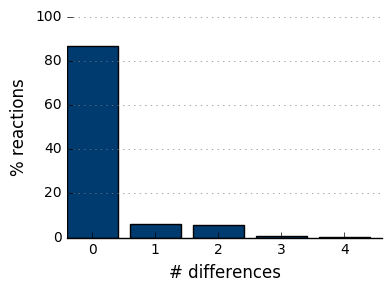

In [11]:
fig = utilsEvaluation.plotNumberDifferences(numDifferences)
# fig.savefig("dataSetB_overall_cmpToIndigoAutomapper.png", dpi=300, format='png', bbox_inches='tight')

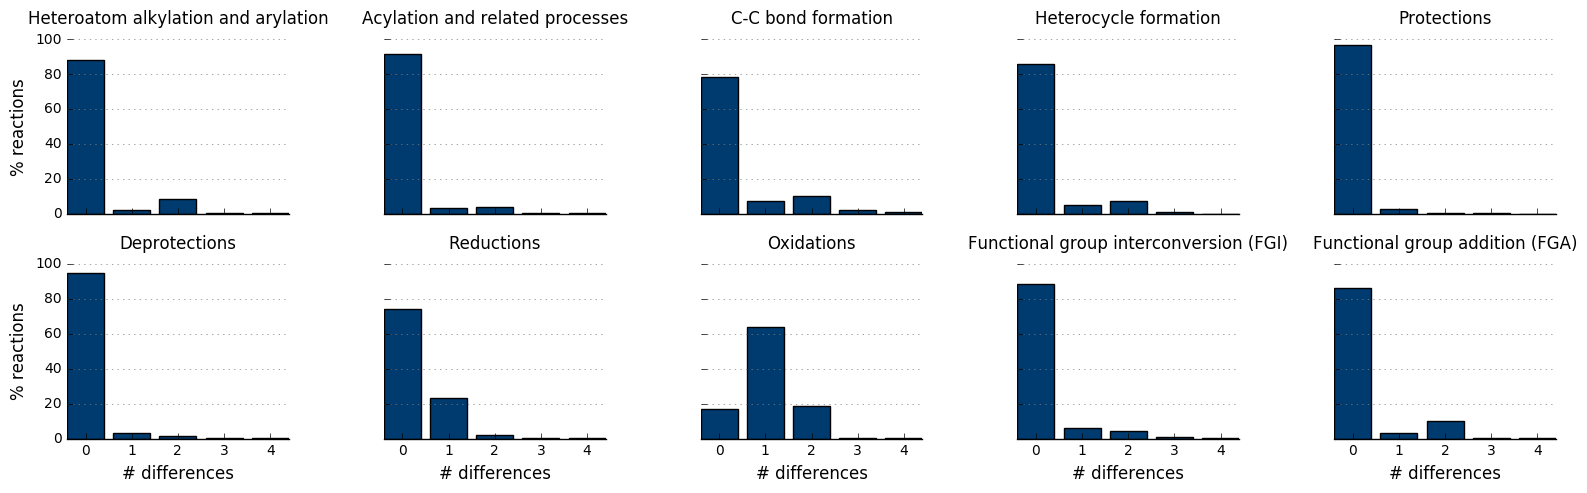

In [12]:
fig = utilsEvaluation.plotNumberDifferencesRxnCls(numDifferences,rxnCls)
# fig.savefig("dataSetB_rxnclasses_cmpToIndigoAutomapper.png", dpi=300, format='png', bbox_inches='tight')

Compare Indigo Automapper KNIME node assignment with NameRxn reactants assignment

In [16]:
numDifferences=defaultdict(list)
for cls,smiNameRxn,reactsNameRxn,smiIndigoTK,reactsIndigo in zip(dataSetB['rxn_Class'],dataSetB['rxnSmiles_Mapping_NameRxn'],\
                                                      dataSetB['reactantSet_NameRxn'],\
                                                      dataSetB['rxnSmiles_IndigoAutoMapperKNIME'],\
                                                      dataSetB['reactantSet_IndigoAutoMapperKNIME']):
    
    rxn = AllChem.ReactionFromSmarts(str(smiNameRxn),useSmiles=True)
    AllChem.RemoveMappingNumbersFromReactions(rxn)
    foundReacts1=[]
    for i in list(reactsNameRxn):
        mol = rxn.GetReactantTemplate(i)
        Chem.SanitizeMol(mol)
        foundReacts1.append(Chem.MolToSmiles(mol))
    foundReacts1 = Counter(foundReacts1)
    rxn = AllChem.ReactionFromSmarts(str(smiIndigoTK).split()[0],useSmiles=True)
    AllChem.RemoveMappingNumbersFromReactions(rxn)
    foundReacts2=[]
    for i in list(reactsIndigo):
        mol = rxn.GetReactantTemplate(i)
        Chem.SanitizeMol(mol)
        foundReacts2.append(Chem.MolToSmiles(mol))
    foundReacts2 = Counter(foundReacts2)
    diffs = set(foundReacts1.items()).symmetric_difference(set(foundReacts2.items()))
    numDifferences[cls].append([len(diffs),reactsNameRxn])

[0.86836, 0.06152, 0.05848, 0.00714, 0.00314]


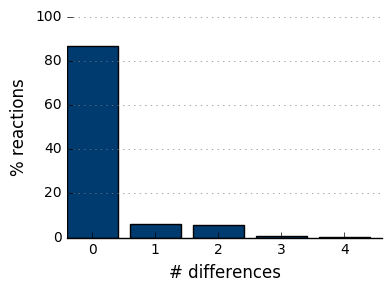

In [17]:
fig = utilsEvaluation.plotNumberDifferences(numDifferences)
# fig.savefig("dataSetB_overall_cmpIndigoAutomapperRxnName.png", dpi=300, format='png', bbox_inches='tight')

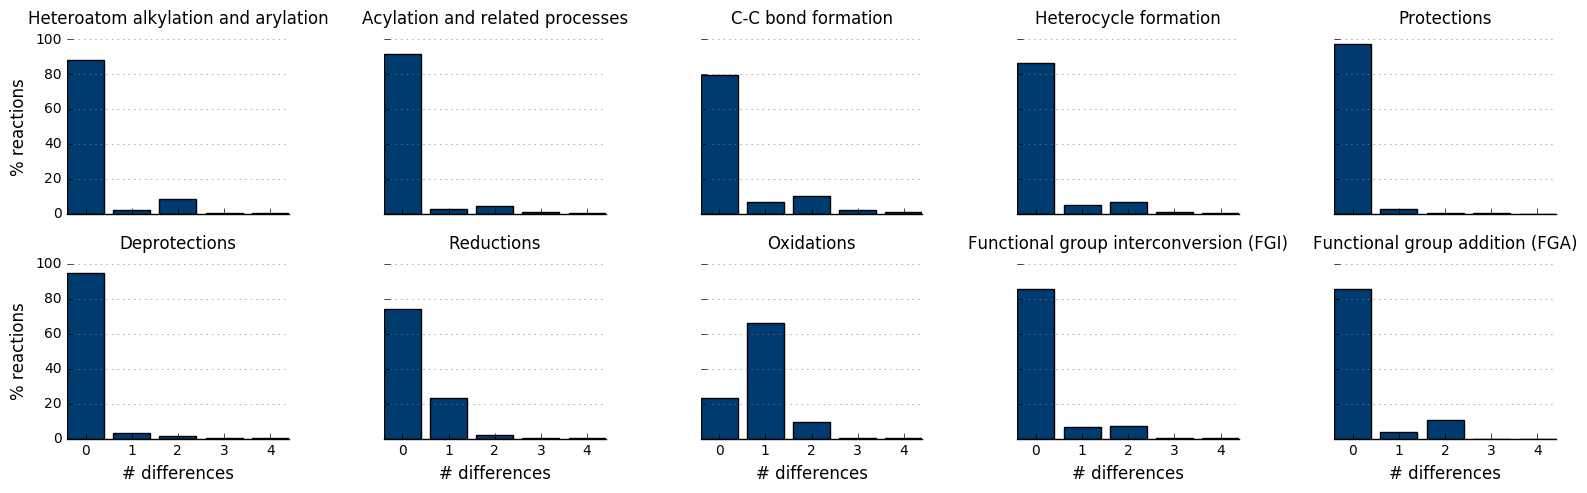

In [18]:
fig = utilsEvaluation.plotNumberDifferencesRxnCls(numDifferences,rxnCls)
# fig.savefig("dataSetB_rxnclasses_cmpIndigoAutomapperRxnName.png", dpi=300, format='png', bbox_inches='tight')

#### Get the incomplete mappings of Indigo Automapper on data set B and assign for those reaction roles

In [12]:
incomplMapping=[]
ids=dataSetB.index
for idx,smi,mc in zip(ids,dataSetB['rxnSmiles_IndigoAutoMapperKNIME'], dataSetB['IndigoAutoMapperKNIME_Mapping_Complete']):
    if not mc:
        new_smi = identifyReactants.reassignReactionRoles(str(smi).split()[0])
        incomplMapping.append([idx,new_smi])

In [13]:
len(incomplMapping)

1735

In [14]:
tmp = pd.DataFrame(incomplMapping,columns=['idx','smiles'])
tmp.to_csv('data/incompleteIndigoMappings_dataSetB.csv')

#### Run this subset again in KNIME using the Indigo Automapper and inspect the results

In [15]:
new_results = pd.read_csv('data/incompleteIndigoMappings_dataSetB_results.csv', header=None, names=['indigoNew'])

In [16]:
t = dataSetB.loc[list(new_results.index)]

In [17]:
tt = pd.DataFrame(zip(list(t['patentID']), list(t['rxnSmiles_IndigoAutoMapperKNIME'])), \
                  columns=['pid','indigoBefore'], index=list(t.index))

In [18]:
resultsSubset = pd.concat([tt, new_results],axis=1)

In [19]:
resultsSubset.head()

,pid,indigoBefore,indigoNew
31,US04298535,C=[C:2]1[CH:7]2[C:8]([C:10](=[CH2:11])[CH:5]([...,C=[C:2]1[CH:7]2[C:8]([C:10](=[CH2:11])[CH:5]([...
52,US20140235623A1,C1OCCOC1.[CH3:7][NH:8][c:9]1[c:15]([C:16]#[N:1...,O=C=[N:3][C:4]([c:6]1[cH:11][cH:10][cH:9][cH:8...
64,US20070066624A1,C1COCC1.[CH3:6][C:7]([O:10][C:11]([N:13]1[CH2:...,CN=[C:3]=[O:4].[CH3:5][C:6]([O:9][C:10]([N:12]...
68,US20150218170A1,[CH3:1][C:2]([O-])([CH3:4])[CH3:3].C[CH2:7][O:...,[CH3:1][C:2]([NH:5][C:6]([c:8]1[c:20]2[n:21][c...
80,US04233318,CCN=[C:4]=[S:5].[NH2:6][CH2:7][c:8]1[cH:13][cH...,[CH3:1][CH2:2][N:3]=C=S.[NH2:6][CH2:7][c:8]1[c...


In [20]:
def getNumMappedAtoms(data, smilesColumnName):
    results=[]
    for smi in data[smilesColumnName]:
        rxn=AllChem.ReactionFromSmarts(str(smi).split()[0],useSmiles=True)
        mappingNumsR=0
        numAtmsR=0
        for i in range(rxn.GetNumReactantTemplates()):
            r = rxn.GetReactantTemplate(i)
            tmp=0
            for a in r.GetAtoms():
                if a.HasProp('molAtomMapNumber'):
                    tmp+=1
            if tmp > 0:
                numAtmsR+=r.GetNumAtoms()
                mappingNumsR+=tmp
            countMappingNums1=0
        mappingNumsP=0
        numAtmsP=0
        for i in range(rxn.GetNumProductTemplates()):
            p = rxn.GetProductTemplate(i)
            tmp=0
            for a in p.GetAtoms():
                if a.HasProp('molAtomMapNumber'):
                    tmp+=1
            if tmp > 0:
                numAtmsP+=p.GetNumAtoms()
                mappingNumsP+=tmp
        results.append([numAtmsR,mappingNumsR,numAtmsP,mappingNumsP])
    return results

Get the number of mapped atoms for reactants and products

In [21]:
resultsBefore = getNumMappedAtoms(resultsSubset, 'indigoBefore')
resultsAfter = getNumMappedAtoms(resultsSubset, 'indigoNew')

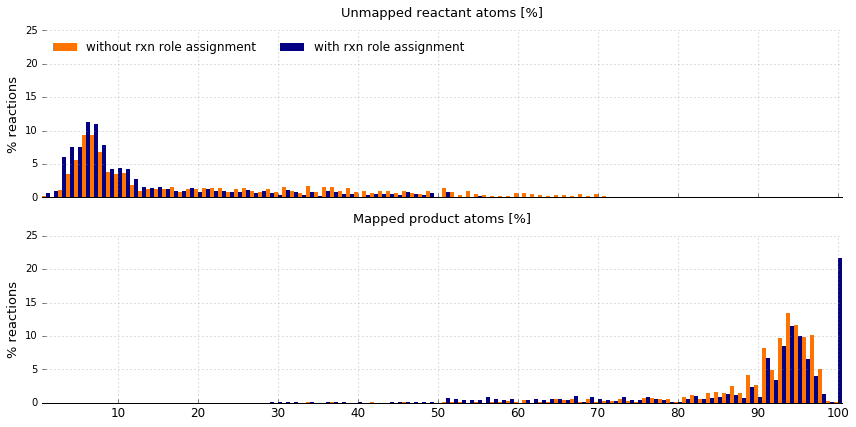

In [22]:
resultsBefore = np.array(resultsBefore)
unmappedRAtoms=((resultsBefore[:,0]-resultsBefore[:,1]).astype(float)/resultsBefore[:,0])*100.0
mappedPAtoms=((resultsBefore[:,2]-resultsBefore[:,3]).astype(float)/resultsBefore[:,2])*(-100.0)+100.0

resultsAfter = np.array(resultsAfter)
unmappedRAtoms2=((resultsAfter[:,0]-resultsAfter[:,1]).astype(float)/resultsAfter[:,0])*100.0
mappedPAtoms2=((resultsAfter[:,2]-resultsAfter[:,3]).astype(float)/resultsAfter[:,2])*(-100.0)+100.0

hist1 = np.histogram(unmappedRAtoms, bins=np.arange(0,101,1))
hist1a = np.histogram(mappedPAtoms, bins=np.arange(0,101,1))
hist2 = np.histogram(unmappedRAtoms2, bins=np.arange(0,101,1))
hist2a = np.histogram(mappedPAtoms2, bins=np.arange(0,101,1))

fig,axes = plt.subplots(2,1,sharex=True,dpi=300, figsize=(12,6))

bins  = np.arange(1,101,1)
bins2  = np.arange(10,110,10)

values1 = (hist1[0]/float(hist1[0].sum()))*100.0
values3 = (hist2[0]/float(hist2[0].sum()))*100.0

b = axes[0].bar(bins, values1, color='#ff7400', width = 0.5, edgecolor = "none",label='without rxn role assignment')
b = axes[0].bar(bins+0.5, values3, color='#040083', width = 0.5, edgecolor = "none",label='with rxn role assignment')
axes[0].set_xticks(bins2 + 0.5)
axes[0].set_xticklabels(bins2,fontsize=12)
axes[0].set_yticks(np.arange(0,40,5))
axes[0].set_ylim(0,25)
ttl = axes[0].set_title('Unmapped reactant atoms [%]',fontsize=13)
ttl.set_position([.5, 1.05])
axes[0].set_ylabel('% reactions',fontsize=13)
axes[0].xaxis.grid(b=True, which='major', color='gray', linestyle=':',linewidth=0.5)
utilsEvaluation.setPlotProperties(axes[0])
ldg = axes[0].legend(frameon=False,loc=2, ncol=2)

values2 = (hist1a[0]/float(hist1a[0].sum()))*100.0
values4 = (hist2a[0]/float(hist2a[0].sum()))*100.0

b = axes[1].bar(bins, values2, color='#ff7400', width = 0.5, edgecolor = "none")
b = axes[1].bar(bins+0.5, values4, color='#040083', width = 0.5, edgecolor = "none")
axes[1].set_xticks(bins2  + 0.5)
axes[1].set_xticklabels(bins2,fontsize=12)
axes[1].set_yticks(np.arange(0,40,5))
axes[1].set_ylim(0,25)
ttl = axes[1].set_title('Mapped product atoms [%]',fontsize=13)
ttl.set_position([.5, 1.05])
axes[1].set_ylabel('% reactions',fontsize=13)
axes[1].xaxis.grid(b=True, which='major', color='gray', linestyle=':',linewidth=0.5)
utilsEvaluation.setPlotProperties(axes[1])

plt.tight_layout()
# fig.savefig("incompleteRXN_AutoMapperIndigo_AfterRXNRoleAssignment.png", dpi=300, format='png', bbox_inches='tight')

In [23]:
print(np.argsort(mappedPAtoms2-mappedPAtoms)[-10:])

[ 644  562 1118 1287  583 1342  808 1325  214  917]


Inspect results in detail

In [24]:
def showDetailedExamples(data, idx):
    smi = data.iloc[idx]['indigoBefore']
    smi2 = data.iloc[idx]['indigoNew']
    print("Patent ID: ",data.iloc[idx]['pid'])
    rxn1 = AllChem.ReactionFromSmarts(str(smi).split()[0],useSmiles=True)
    rxn2 = AllChem.ReactionFromSmarts(str(smi2).split()[0],useSmiles=True)
    print("Mapping by the Indigo Automapper before RXN roles were assigned")
    display(rxn1)
    print("Mapping by the Indigo Automapper after RXN roles were assigned")
    display(rxn2)

Patent ID:  US20110183989A1
Mapping by the Indigo Automapper before RXN roles were assigned


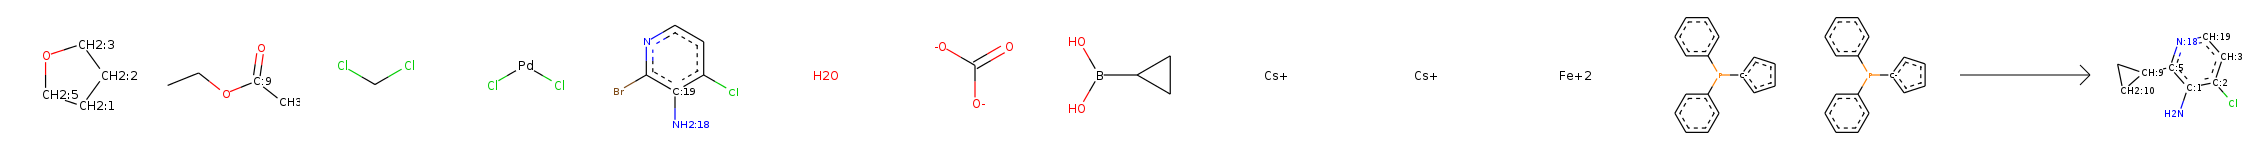

Mapping by the Indigo Automapper after RXN roles were assigned


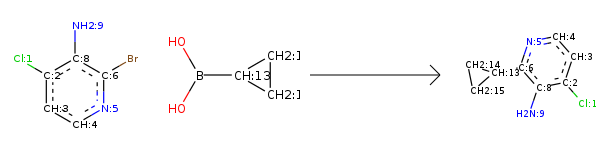

In [25]:
idx= 583 #1342 #214
showDetailedExamples(resultsSubset,idx)